In [1]:
from astropy.table import Table, QTable, join, vstack
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants

import numpy as np

import os

import matplotlib.pyplot as plt

In [2]:
c = constants.c.to('km/s')

h = 1
H0 = 100*h

# Read in list of observed PV targets

Generate an updated version of this by running

`bash td_from_program PV > PV_MMDDYYYY.txt`

from the `/global/cscratch1/sd/kadglass` directory.

Last updated: 5/4/2021 (19,697 observations)


*Alternate*: Read in Segev's file that has pre-merged all the PV targets with ??? (so that it also has FIBER_RA, FIBER_DEC).

In [3]:
PV_filename = '/global/project/projectdirs/desi/science/td/pv/pv_redshifts.fits'

hdu = fits.open(PV_filename)
PV_observed = QTable(hdu[1].data)
hdu.close()

In [2]:
'''
PV_filename = 'PV_05042021.txt'

PV_observed = Table.read(PV_filename, 
                         format='ascii.no_header', 
                         delimiter='|', 
                         names=['PROGRAM', 'RA', 'DEC', 'TARGETID', 'TILEID', 'DATE', 'PETAL'])
'''

In [4]:
PV_observed[:10]

PROGRAM,TARGETID,DATE,PETAL,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,BRICKNAME,EBV,FLUX_W1,FLUX_W2,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,DELTA_X,DELTA_Y,FIBER_RA,FIBER_DEC,EXPTIME,PSF_TO_FIBER_SPECFLUX,NIGHT,EXPID,MJD,TILEID,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET
str14,int64,int64,int64,float64,float64,float64,float64,int64,int64,str6,str20,int64,float64,int32,int32,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,str3,float32,float32,int32,float64,int32,int16,int32,int32,str4,float32,float32,float32,float32,float32,float32,int16,int64,str2,float32,float32,float32,float32,str8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,int32,int64,int64,int64,int64,int64,int64,int64,int64
PV_BRIGHT_HIGH,1070167824007172,20210407,3,8.999999999999996e+99,0.0 .. 0.0,-0.0019956912923479522,4.1311493573349107e-48,1570,0,STAR,CV,3,1.942668892225729e+84,0,1,3,126,3126,1561,520,149.17168454531367,2.1606061697023886,0.0,0.0,2015.5,5400.0,4611686018427387904,1,TGT,218.7591,22.851889,1700,0.08333187011324772,63,0,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0,0,,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,1700,5,4611686018427387904,0,0,8796093022208,0,0,0,2,218.591,24.332,0.164,-1.497,149.17234133638783,2.16668704929515,363.6893,0.0,20210407,83857,59312.12040935,13,999999,999999,999999,999999,999999,999999,999999,999999
PV_DARK_HIGH,39627841578469278,20210407,3,17148.387557289563,16209.006182028303 .. 785.5877391604446,0.02054345522768439,8.46910168200425e-06,0,7883,GALAXY,,10,16801.057623653323,0,1,3,422,3422,1608,0,148.5845659928287,2.297555665360112,0.0,0.0,2015.5,5400.0,5764607523034234880,1,TGT,371.95776,58.218826,102100,0.9313062399242229,516,9010,343922,1950,SER,626.78143,1314.678,2223.09,15.280941,5.4766994,2.3428705,4096,1174177,L3,0.0,0.0,0.0,0.0,1486p022,0.046209376,1496.5332,842.5231,0.20871176,0.11013782,77.07959,161.67491,273.38855,77.07959,161.67491,273.38855,3.7954614,5.1538677,-0.01629305,0.4088024,S,102100,9,5764607523034234880,131074,0,79164837199872,0,0,0,2,371.946,58.165,-0.006,0.009,148.58454347463746,2.297519724676011,363.6893,0.7176397801276115,20210407,83857,59312.12040935,13,999999,999999,999999,999999,999999,999999,999999,999999
PV_DARK_HIGH,39627841578472216,20210407,3,9492.489168858156,2976.9202876603476 .. 194.21012576284306,0.0996967217194942,3.7192873625077817e-05,0,7910,GALAXY,,10,1609.718369731214,0,1,3,359,3359,1994,0,148.72031563724784,2.356287147124274,0.0,0.0,2015.5,5400.0,5764607523034234880,1,TGT,335.72443,72.530365,102100,0.005271210879649324,516,9010,343922,4888,SER,74.09307,181.23122,343.75922,47.865936,21.386744,7.375445,0,3846821410379372928,G2,19.512455,18.819262,17.334963,0.0,1486p022,0.04297064,268.97052,167.8382,0.57354385,0.20062122,12.131433,29.673414,56.284508,12.139204,29.68583,56.301956,6.0,4.5534487,0.21458071,0.077153556,S,102100,9,5764607523034234880,131074,0,79164837199872,0,0,0,2,335.717,72.487,-0.007,0.005,148.72028902389746,2.356266856581495,363.6893,0.7269558

# Identify which of these targets are SGA galaxies

Only because I care about the Tully-Fisher relation and not the Fundamental Plane.  All Tully-Fisher objects are also SGA objects.

### Read in SGA catalog

In [5]:
SGA_filename = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/masking/SGA-ellipse-v3.0.kd.fits'

hdu = fits.open(SGA_filename)
SGA = QTable(hdu[1].data)
hdu.close()

In [6]:
SGA[:10]

SGA_ID,GALAXY,PGC,SGA_RA,SGA_DEC,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,IN_FOOTPRINT,IN_FOOTPRINT_GRZ,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,DIAM,DIAM_REF,PA,BA,ELLIPSEBIT,DROPBIT,RELEASE,BRICKID,OBJID,BRICK_PRIMARY,MASKBITS,ITERATIVE,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,BX,BY,DCHISQ [5],EBV,MJD_MIN,MJD_MAX,REF_CAT,REF_ID,PMRA,PMDEC,PARALLAX,PMRA_IVAR,PMDEC_IVAR,PARALLAX_IVAR,REF_EPOCH,GAIA_POINTSOURCE,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_G_N_OBS,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_N_OBS,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_N_OBS,GAIA_PHOT_VARIABLE_FLAG,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_ASTROMETRIC_EXCESS_NOISE_SIG,GAIA_ASTROMETRIC_N_OBS_AL,GAIA_ASTROMETRIC_N_GOOD_OBS_AL,GAIA_ASTROMETRIC_WEIGHT_AL,GAIA_DUPLICATED_SOURCE,GAIA_A_G_VAL,GAIA_E_BP_MIN_RP_VAL,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,APFLUX_G [8],APFLUX_R [8],APFLUX_Z [8],APFLUX_RESID_G [8],APFLUX_RESID_R [8],APFLUX_RESID_Z [8],APFLUX_BLOBRESID_G [8],APFLUX_BLOBRESID_R [8],APFLUX_BLOBRESID_Z [8],APFLUX_IVAR_G [8],APFLUX_IVAR_R [8],APFLUX_IVAR_Z [8],APFLUX_MASKED_G [8],APFLUX_MASKED_R [8],APFLUX_MASKED_Z [8],APFLUX_W1 [5],APFLUX_W2 [5],APFLUX_W3 [5],APFLUX_W4 [5],APFLUX_RESID_W1 [5],APFLUX_RESID_W2 [5],APFLUX_RESID_W3 [5],APFLUX_RESID_W4 [5],APFLUX_IVAR_W1 [5],APFLUX_IVAR_W2 [5],APFLUX_IVAR_W3 [5],APFLUX_IVAR_W4 [5],MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_G,NOBS_R,NOBS_Z,NOBS_W1,NOBS_W2,NOBS_W3,NOBS_W4,RCHISQ_G,RCHISQ_R,RCHISQ_Z,RCHISQ_W1,RCHISQ_W2,RCHISQ_W3,RCHISQ_W4,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACFLUX_W1,FRACFLUX_W2,FRACFLUX_W3,FRACFLUX_W4,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,ANYMASK_G,ANYMASK_R,ANYMASK_Z,ALLMASK_G,ALLMASK_R,ALLMASK_Z,WISEMASK_W1,WISEMASK_W2,PSFSIZE_G,PSFSIZE_R,PSFSIZE_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,PSFDEPTH_W1,PSFDEPTH_W2,PSFDEPTH_W3,PSFDEPTH_W4,WISE_COADD_ID,WISE_X,WISE_Y,SERSIC,SERSIC_IVAR,SHAPE_R,SHAPE_R_IVAR,SHAPE_E1,SHAPE_E1_IVAR,SHAPE_E2,SHAPE_E2_IVAR,RADIUS_SB22,RADIUS_SB22.5,RADIUS_SB23,RADIUS_SB23.5,RADIUS_SB24,RADIUS_SB24.5,RADIUS_SB25,RADIUS_SB25.5,RADIUS_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,G_MAG_TOT,R_MAG_TOT,Z_MAG_TOT,PREBURNED,FREEZE
int64,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,bool,bool,int64,str35,int16,bool,float64,float64,float32,str8,float32,str4,float32,float32,int32,int32,int16,int32,int32,bool,int32,bool,str6,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,str2,int64,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,int16,float32,float32,int16,float32,float32,int16,bool,float32,float32,int16,int16,float32,bool,float32,float32,float32,float32,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,f

### Match the observed targets to the SGA catalog by sky position

In [7]:
SGA_coords = SkyCoord(ra=SGA['SGA_RA']*u.degree, dec=SGA['SGA_DEC']*u.degree)
PV_coords = SkyCoord(ra=PV_observed['TARGET_RA']*u.degree, dec=PV_observed['TARGET_DEC']*u.degree)

idx, d2d, d3d = PV_coords.match_to_catalog_sky(SGA_coords)

PV_observed['IDX_SGA'] = idx
PV_observed['SKY_TARGET_DIST_SGA'] = d2d

### Eliminate those objects which are not actually SGA galaxies

Implement a distance maximum

In [8]:
# SGA targets were placed along the semi-major axis, out to a distance of D(26)
sep_constraint = PV_observed['SKY_TARGET_DIST_SGA'] <= 0.5*SGA['DIAM'][PV_observed['IDX_SGA']]*u.arcmin

PV_SGA_observed = PV_observed[sep_constraint]

In [9]:
# Save just the target info to disk (for upoloading to the Legacy Survey viewer)
PV_SGA_observed[['FIBER_RA', 'FIBER_DEC', 'TARGETID']].write('../PV_targets.fits', 
                                                             format='fits', 
                                                             overwrite=True)

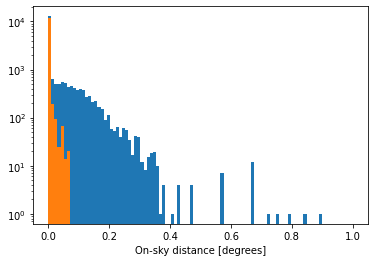

In [11]:
plt.figure()

plt.hist(PV_observed['SKY_TARGET_DIST_SGA'].data, bins=np.linspace(0, 1, 100))
plt.hist(PV_SGA_observed['SKY_TARGET_DIST_SGA'].data, bins=np.linspace(0,1,100))

plt.yscale('log')

plt.xlabel('On-sky distance [degrees]');

# Locate and extract the Redrock redshifts for each of the observed TF spectra

**Note**: Already included in Segev's merged PV catalog

### Add columns to table

In [19]:
'''
redux = 'daily'

ztable = None

for i, pv_target in enumerate(PV_SGA_observed):
    zbdir = '{}/{}/tiles/{}/{}'.format(os.environ['DESI_SPECTRO_REDUX'], redux, pv_target['TILEID'], pv_target['DATE'])
    zbfile = '{}/zbest-{}-{}-{}.fits'.format(zbdir, pv_target['PETAL'], pv_target['TILEID'], pv_target['DATE'])
    
    if os.path.exists(zbfile):
        hdus = fits.open(zbfile)
        zbest = hdus['ZBEST'].data
        select = zbest['TARGETID'] == pv_target['TARGETID']
        
        if ztable is None:
            ztable = join(pv_target, zbest[select], keys='TARGETID')
        else:
            ztable = vstack([ztable, join(pv_target, zbest[select], keys='TARGETID')])
            
    if (i+1)%100 == 0:
        print('{} out of {}'.format(i+1, len(PV_SGA_observed)))
''';

In [29]:
# Save file to disk
ztable_filename = '../PV_SGA_z_05062021.fits'

PV_SGA_observed.write(ztable_filename[:-4]+'.fits', format='fits', overwrite=True)

In [5]:
# Read in saved file from disk
PV_SGA_observed = QTable.read('../PV_SGA_z_05062021.fits')

# Calculate the rotational velocity for each axis target

First, we need to find the galaxy's central redshift (if it exists).

In [12]:
LSS_directory = '/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/v0/'
BGS_filename = LSS_directory + 'ALLAlltiles_bright_full.dat.fits'

hdu = fits.open(BGS_filename)
BGS = QTable(hdu[1].data)
hdu.close()

BGS[:10]

TARGETID,FIBER,LOCATION_AVAIL,RA,DEC,REF_EPOCH,PARALLAX,PMRA,PMDEC,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,SV3_SCND_TARGET,NUMOBS_MORE,NUMOBS,ZTILEID,TARGET_STATE,TIMESTAMP,VERSION,RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_W1,FLUX_IVAR_W2,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,WISEMASK_W1,WISEMASK_W2,MASKBITS,PHOTSYS,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE,LOCATION,FIBERSTATUS,OBJTYPE,PRIORITY,DELTA_X,DELTA_Y,EXPTIME,PSF_TO_FIBER_SPECFLUX,INTEG_COADD_FLUX_B,MEDIAN_COADD_FLUX_B,MEDIAN_COADD_SNR_B,INTEG_COADD_FLUX_R,MEDIAN_COADD_FLUX_R,MEDIAN_COADD_SNR_R,INTEG_COADD_FLUX_Z,MEDIAN_COADD_FLUX_Z,MEDIAN_COADD_SNR_Z,TSNR2_ELG_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_ELG_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_ELG_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_ELG,TSNR2_LYA,TSNR2_BGS,TSNR2_QSO,TSNR2_LRG,LOCATION_ASSIGNED,PRIORITY_ASSIGNED,TILE,TILELOCID,sort
int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,int64,int64,float64,int32,int64,int64,int64,int64,int64,int32,str18,str25,str14,int16,int32,str8,int32,str4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,str1,float64,float64,float64,float64,int64,int64,str6,str20,int64,float64,int32,int32,int64,int32,str3,int32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int32,str100,int32,float64
39627733986185045,510,1416,215.68326766406273,-2.126343779734331,0.0,0.0,0.0,0.0,1152921504606846976,65537,0,0.9513084672654937,516,102000,9,0,9,0,-1,BGS|UNOBS,2021-04-04T23:14:10,0.57.0,9010,318270,2156m022,3925,SER,0.049666792,6.186808,12.121645,17.673355,311.87714,125.650314,14.544479,0.86327344,0.90570873,0.94610953,0.014184044,0.01055459,0.008804796,0.0067322217,0.0061529484,0.007780342,0.99801034,0.9980223,0.9973761,4,3,2,1871.8307,704.9228,66.051865,1051.2617,406.4031,39.579597,18.519192,14.11583,2.4464688,0.5924837,0.9916183,0.9948442,0,0,0,1.4475453,2.836136,4.1350856,1.4477924,2.8365011,4.1354885,0,0,0,S,1e+20,1e+20 .. 1e+20,1e+20,1e+20,999999,999999,N/A,N/A,999999,1e+20,999999,999999,999999,999999,N/A,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,0,999999,229,2291416,-0.0
39627733990378402,379,512,215.88599828288602,-2.134975070131483,2015.5,0.3163019,-7.9261055,-9.808308,2305843052163366912,0,1280,0.9837290212748808,519,101500,9,0,9,0,-1,MWS|UNOBS,2021-04-04T23:14:10,0.57.0,9010,318271,2158m022,2978,PSF,0.048978835,92.77103,117.25169,120.596146,59.34922,39.075226,11.619769,0.86503327,0.906952,0.94683576,2.3536516e-06,0.000682388,0.0016918794,0.20361365,0.2721581,0.0062725265,0.69899666,0.6665447,0.50010556,2,2,1,1251.8617,480.0708,33.939564,683.6639,278.2036,17.857145,25.451717,12.862991,2.7218666,0.67536116,0.9917339,0.9949154,0,0,0,71.838295,90.79517,93.38499,71.838295,90.79517,93.38499,0,0,0,S,1e+20,1e+20 .. 1e+20,1e

#### Build a SkyCoord object for the BGS catalog so that we can match the SGA galaxies to it.

In [13]:
BGS_coords = SkyCoord(ra=BGS['RA']*u.degree, dec=BGS['DEC']*u.degree)

SGA_idx, SGA_d2d, SGA_d3d = SGA_coords.match_to_catalog_sky(BGS_coords)

SGA['IDX_BGS'] = SGA_idx
SGA['SKY_TARGET_DIST_BGS'] = SGA_d2d

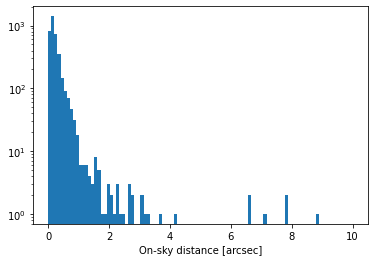

In [14]:
plt.figure()
plt.hist(SGA['SKY_TARGET_DIST_BGS'].to(u.arcsec).data, bins=np.linspace(0,10,100))
plt.xlabel('On-sky distance [arcsec]')
plt.yscale('log')

Matches correspond to objects with sky separations < 5".

In [16]:
SGA['Z'] = np.nan*np.ones(len(SGA))
SGA['ZERR'] = np.nan*np.ones(len(SGA))

SGA_matches = SGA['SKY_TARGET_DIST_BGS'].to(u.arcsec) <= 5*u.arcsec

SGA['Z'][SGA_matches] = BGS['Z'][SGA['IDX_BGS'][SGA_matches]]
SGA['ZERR'][SGA_matches] = BGS['ZERR'][SGA['IDX_BGS'][SGA_matches]]
#SGA['TARGETID']

In [17]:
def rot_vel(targets, center):
    '''
    Calculate the rotational velocity of a set of observations based on 
    the difference in redshifts between the observations and the center 
    of the galaxy.
    
    
    PARAMETERS
    ==========
    
    targets : astropy table
        list of observations for a given object.  Field names should include
        SKY_FIBER_DIST_SGA, Z, ZERR
        
    center : astropy table row
        Defining information for the galaxy's center.  Field names should 
        include Z, DIAM (the diameter of the galaxy at 26-mag)
        
    
    RETURNS
    =======
    
    targets : astropy table
        Adds a column with the velocities of the observations relative to 
        the galaxy's center.  Units are km/s.  Also adds a column of the 
        distance to the observation (in units of kpc); the redshift of the 
        galaxy's center is used as the distance proxy.
    '''
    
    ############################################################################
    # Figure out which redshift(s) belong to the galaxy's center - should be the 
    # target closest to the center
    #---------------------------------------------------------------------------
    #center_idx = np.argmin(targets['SKY_DIST_SGA'])
    ############################################################################
    
    
    ############################################################################
    # Calculate the relative velocities
    #---------------------------------------------------------------------------
    targets['V_ROT'] = c*(targets['Z'] - center['Z'])
    
    targets['V_ROT_ERR'] = c*np.sqrt(targets['ZERR']**2 + center['ZERR']**2)
    ############################################################################
    
    
    ############################################################################
    # Calculate the distance to the observations in units of the diameter
    #---------------------------------------------------------------------------
    targets['RADIUS'] = targets['SKY_FIBER_DIST_SGA']/(0.5*center['DIAM']*u.arcmin).to(u.degree)
    ############################################################################
    
    return targets

### Calculate on-sky distance between fiber placements (where the fibers were actually placed, not where the fibers were told to go).

In [18]:
PV_fiber_coords = SkyCoord(ra=PV_SGA_observed['FIBER_RA']*u.degree, 
                           dec=PV_SGA_observed['FIBER_DEC']*u.degree)
#SGA_fiber_coords = SkyCoord(ra=SGA['FIBER_RA']*u.degree, dec=SGA['FIBER_DEC']*u.degree)

PV_SGA_observed['SKY_FIBER_DIST_SGA'] = PV_fiber_coords.separation(SGA_coords[PV_SGA_observed['IDX_SGA']])

In [39]:
PV_SGA_ztable = None

#for i in np.unique(ztable['IDX_SGA']):
for i in np.unique(PV_SGA_observed['IDX_SGA']):
    #idx_bool = ztable['IDX_SGA'] == i
    idx_bool = PV_SGA_observed['IDX_SGA'] == i
    
    #PV_galaxy = ztable[idx_bool]
    PV_galaxy = PV_SGA_observed[idx_bool]
    
    if len(PV_galaxy) > 1 and len(np.unique(PV_galaxy['TARGETID'])) > 1 and np.isfinite(SGA['Z'][i]):
        #print(SGA['GALAXY'][i])
        #ztable[['RA', 'DEC', 'TARGETID', 'Z', 'SPECTYPE']][idx_bool].pprint()
        
        PV_galaxy = rot_vel(PV_galaxy, SGA[i])
        
        if PV_SGA_ztable is None:
            PV_SGA_ztable = PV_galaxy
        else:
            PV_SGA_ztable = vstack([PV_SGA_ztable, PV_galaxy])
        '''
        plt.figure()
        plt.scatter(SGA['SGA_RA'][i], SGA['SGA_DEC'][i], s=50, marker='x')
        plt.scatter(ztable['RA'][idx_bool], ztable['DEC'][idx_bool], s=50)
        plt.xlabel(r'$\alpha$ [degrees]')
        plt.ylabel(r'$\delta$ [degrees]')
        plt.tight_layout()
        
        break
        '''

In [40]:
# Save this full data table to disk
PV_SGA_ztable.write('../PV_SGA_vel_05062021.fits', format='fits')

In [19]:
# Read in latest data table
PV_SGA_ztable = QTable.read('../PV_SGA_vel_05062021.fits', format='fits')

## For any of the large SGA galaxies, plot the rotation curve

Include the MaNGA rotation curve, if it exists.

In [41]:
for i in np.unique(PV_SGA_ztable['IDX_SGA']):
    idx_bool = PV_SGA_ztable['IDX_SGA'] == i
    
    PV_galaxy = PV_SGA_ztable[idx_bool]
    
    ################################################################################
    # Plot rotation curve
    #-------------------------------------------------------------------------------
    plt.figure()
    plt.title(SGA['GALAXY'][i])
    plt.plot(0, 0, 'mo')
    
    if 'GALAXY' in PV_galaxy['SPECTYPE']:
        plt.errorbar(PV_galaxy['RADIUS'][PV_galaxy['SPECTYPE'] == 'GALAXY'], 
                     np.abs(PV_galaxy['V_ROT'][PV_galaxy['SPECTYPE'] == 'GALAXY'].data), 
                     yerr=PV_galaxy['V_ROT_ERR'][PV_galaxy['SPECTYPE'] == 'GALAXY'].data, 
                     fmt='o', c='b', label='Galaxy')
    if 'STAR' in PV_galaxy['SPECTYPE']:
        plt.errorbar(PV_galaxy['RADIUS'][PV_galaxy['SPECTYPE'] == 'STAR'], 
                     np.abs(PV_galaxy['V_ROT'][PV_galaxy['SPECTYPE'] == 'STAR'].data), 
                     yerr=PV_galaxy['V_ROT_ERR'][PV_galaxy['SPECTYPE'] == 'STAR'].data, 
                     fmt='*', c='orange', label='Star')
    if 'QSO' in PV_galaxy['SPECTYPE']:
        plt.errorbar(PV_galaxy['RADIUS'][PV_galaxy['SPECTYPE'] == 'QSO'], 
                     np.abs(PV_galaxy['V_ROT'][PV_galaxy['SPECTYPE'] == 'QSO'].data), 
                     yerr=PV_galaxy['V_ROT_ERR'][PV_galaxy['SPECTYPE'] == 'QSO'].data, 
                     fmt='.', c='g', label='QSO')
    
    for (r,v) in zip(PV_galaxy['RADIUS'].data, np.abs(PV_galaxy['V_ROT'].data)):
        label = '{:.1f}'.format(v)
        
        plt.annotate(label, 
                     (r,v), 
                     textcoords='offset points', 
                     xytext=(10,0), 
                     backgroundcolor='white')
    
    plt.xlabel('Distance from galaxy center [R(26)]')
    plt.ylabel('$V_{rot}$ [km/s]')
    plt.legend()
    plt.tight_layout()
    
    plt.savefig('../images/PV_curves/'+SGA['GALAXY'][i]+'.png', dpi=300)
    plt.close()
    ################################################################################
    
    #break

#### Only plot those curves with multiple good velocity values

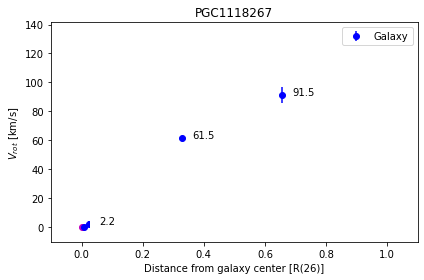

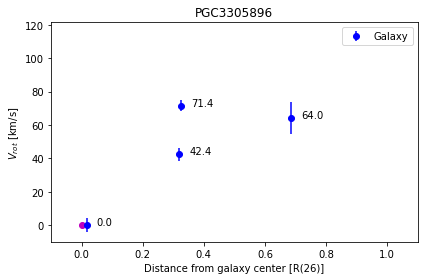

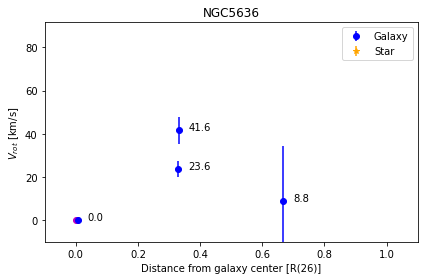

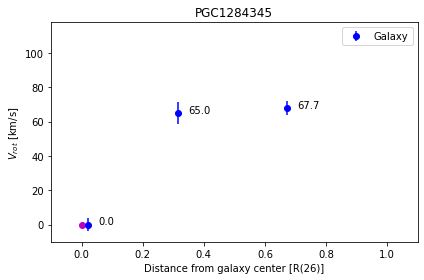

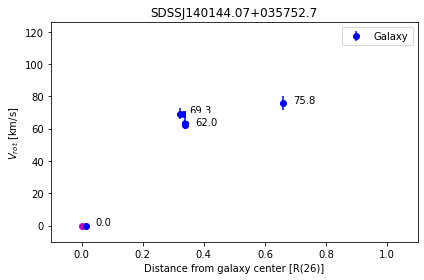

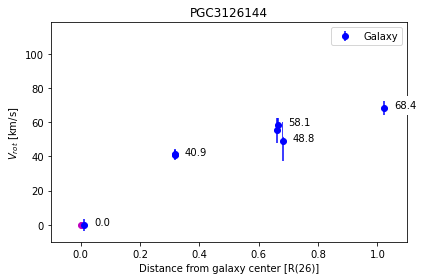

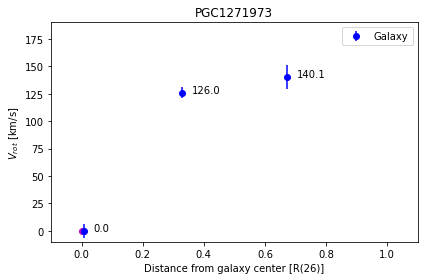

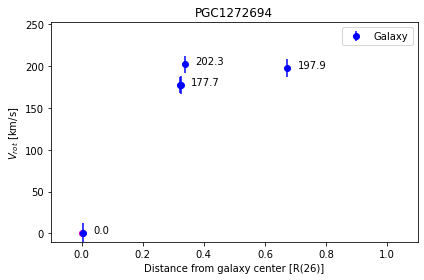

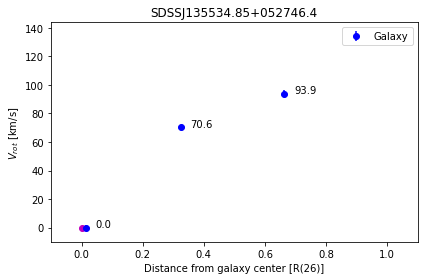

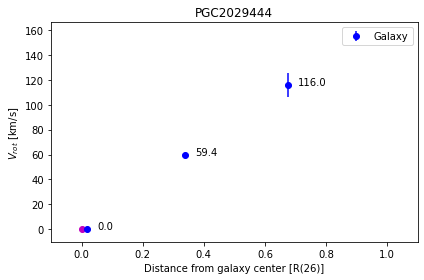

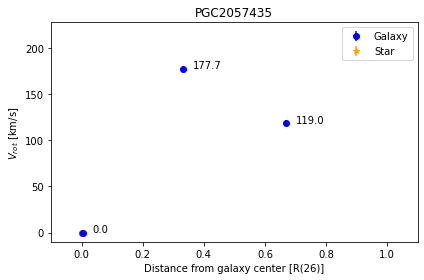

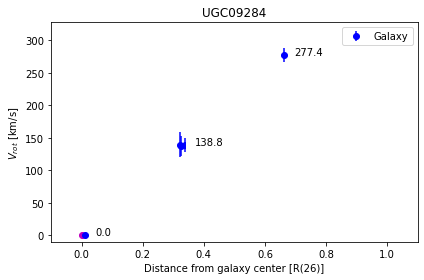

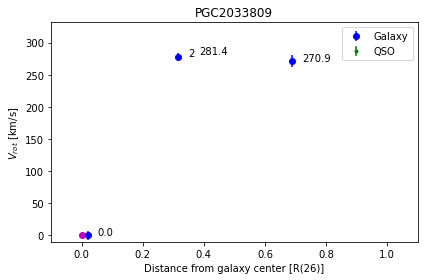

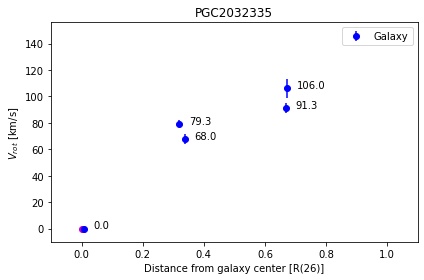

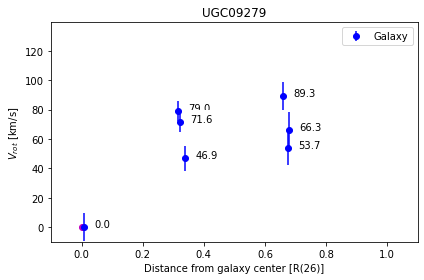

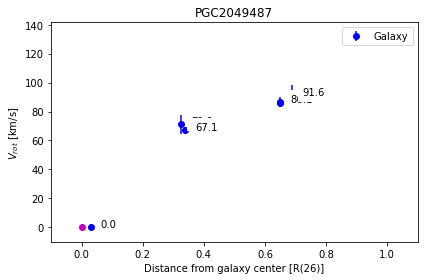

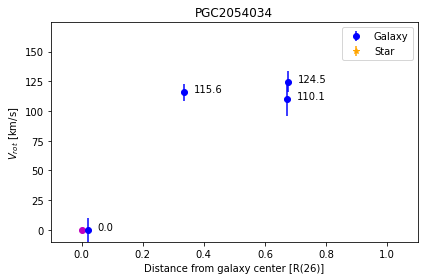

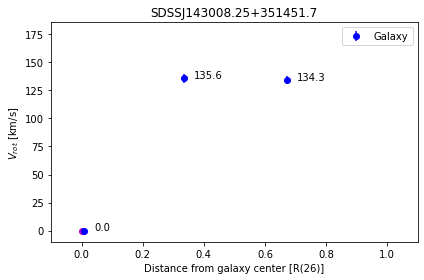

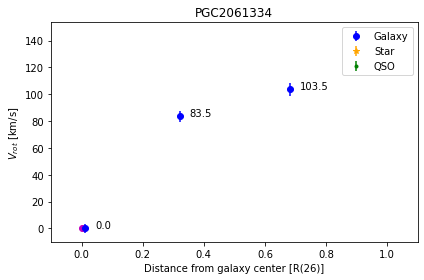

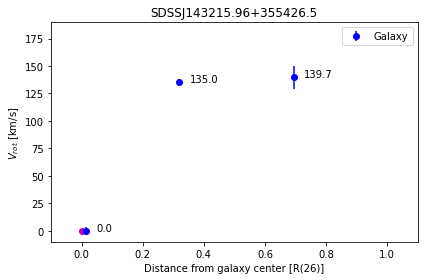

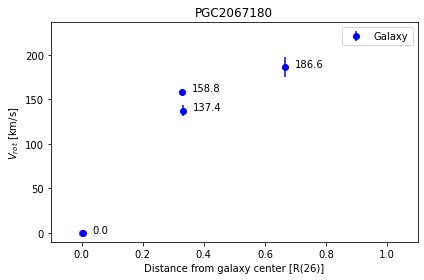

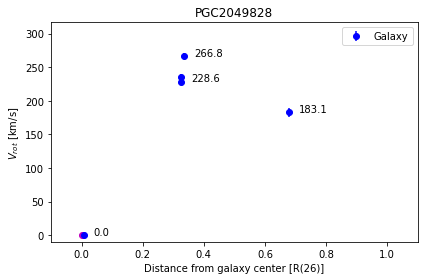

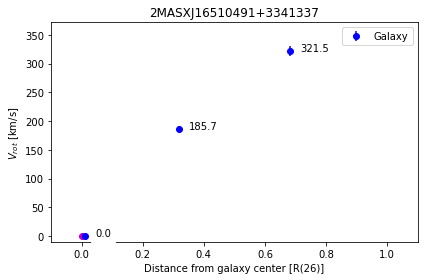

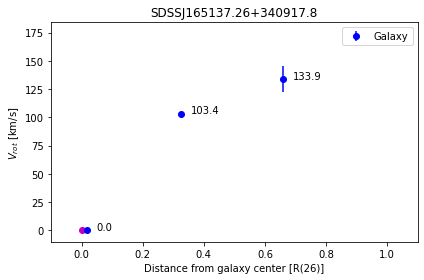

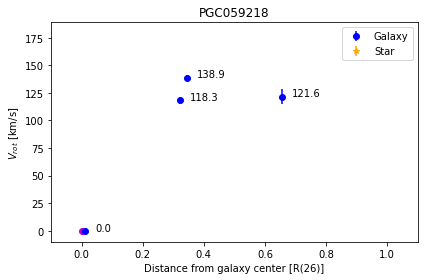

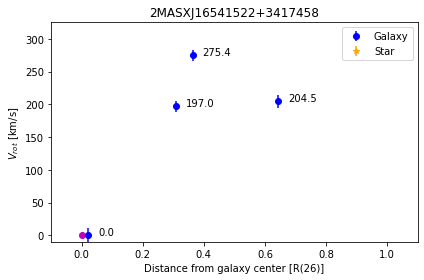

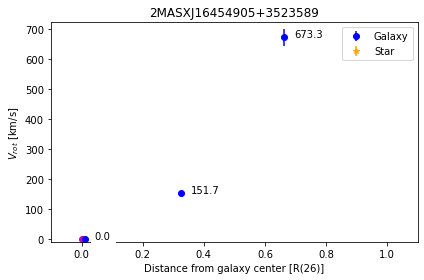

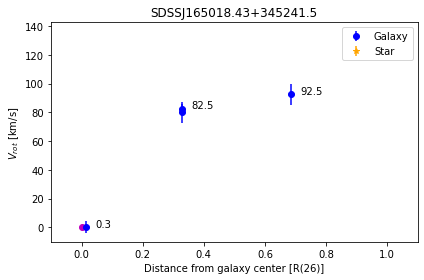

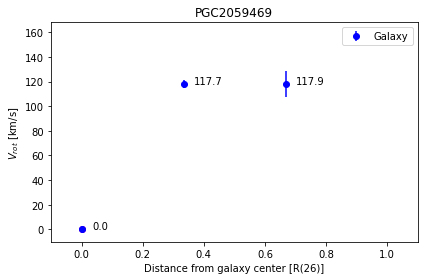

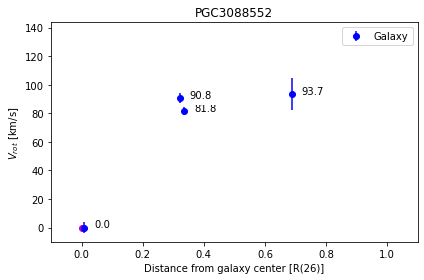

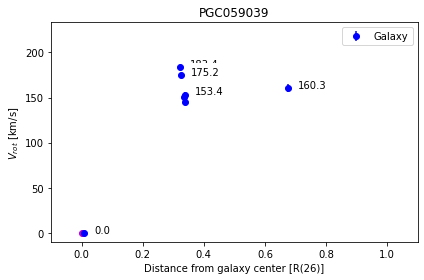

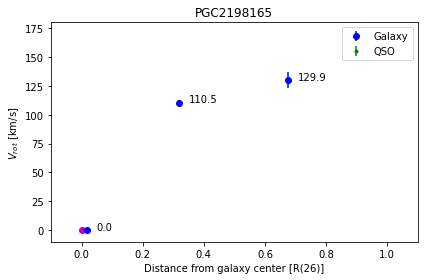

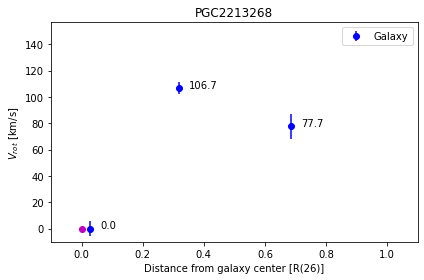

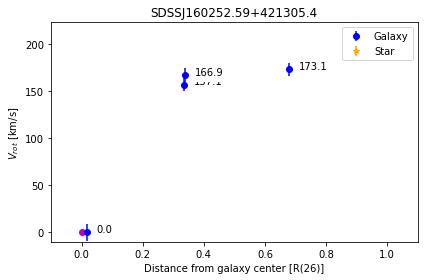

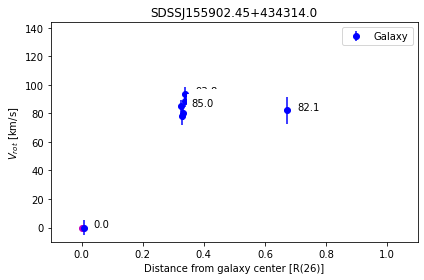

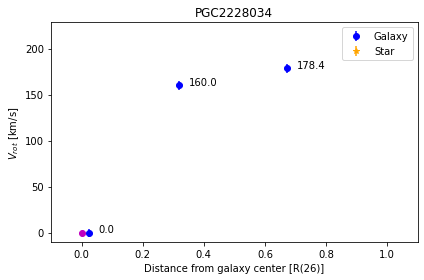

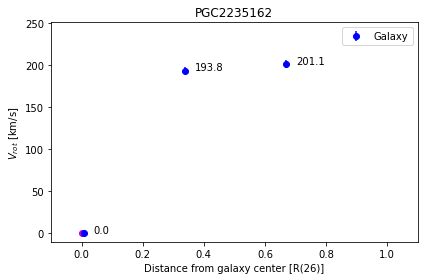

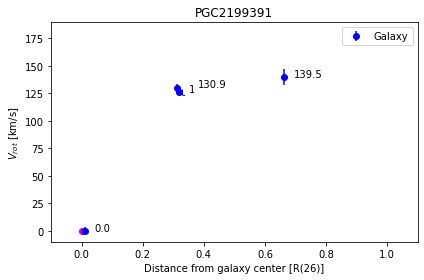

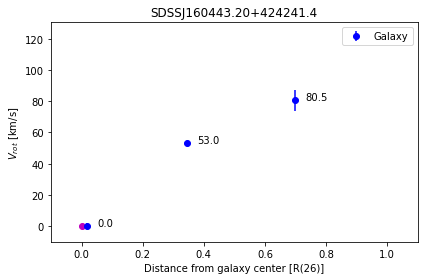

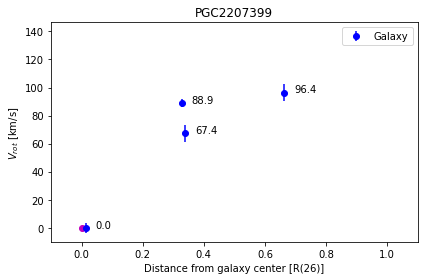

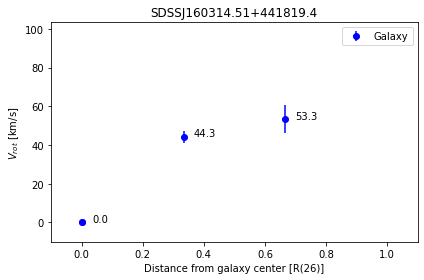

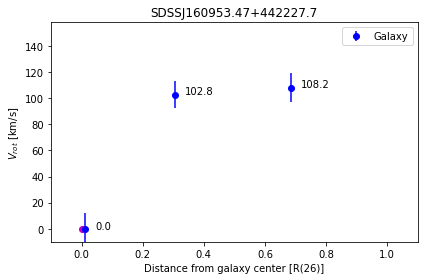

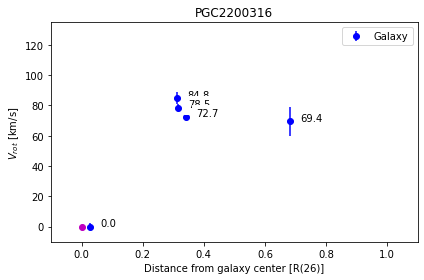

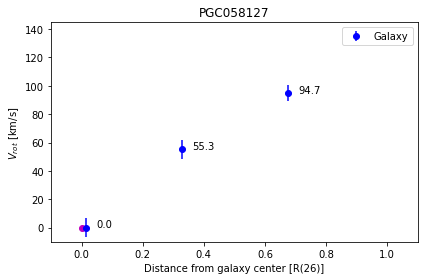

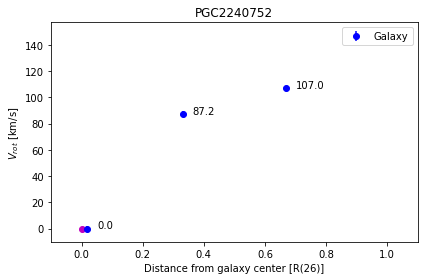

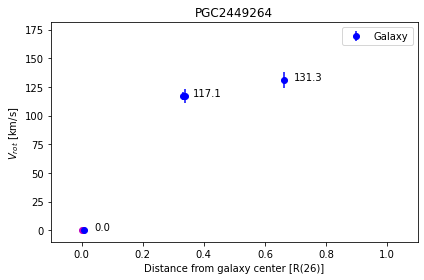

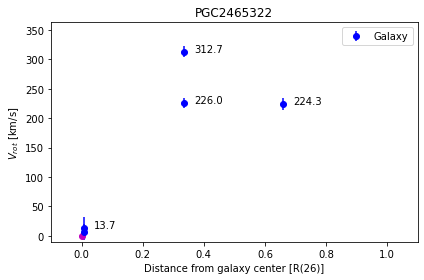

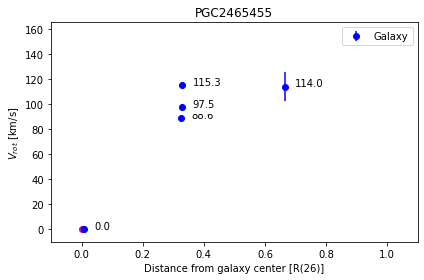

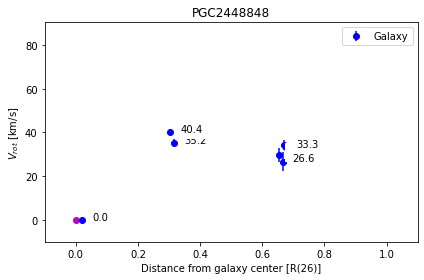

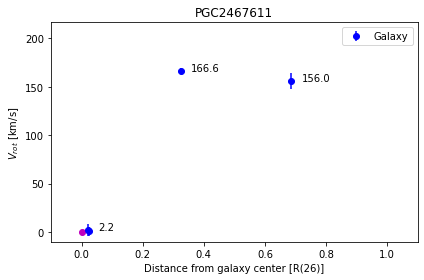

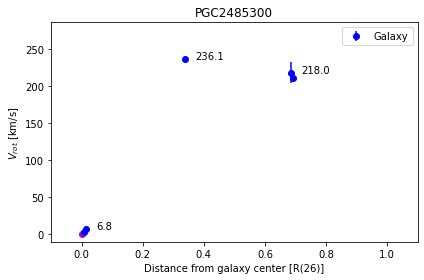

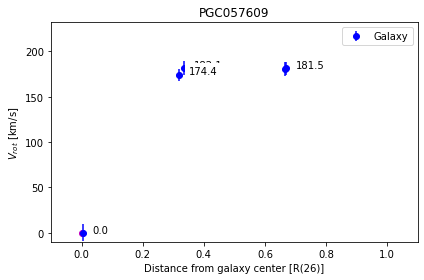

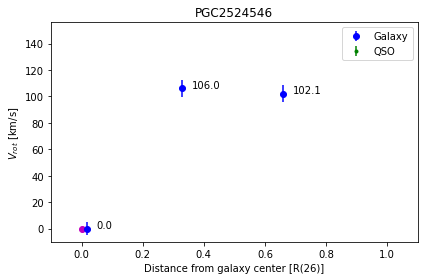

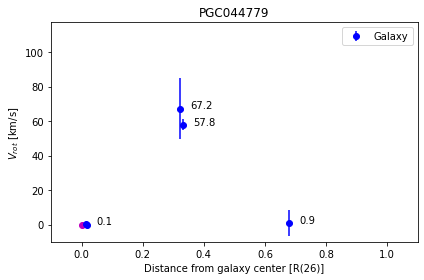

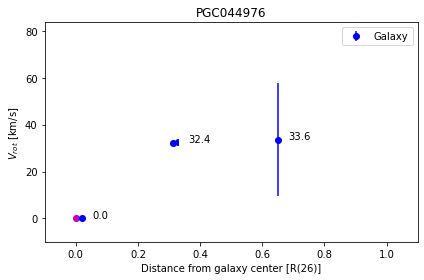

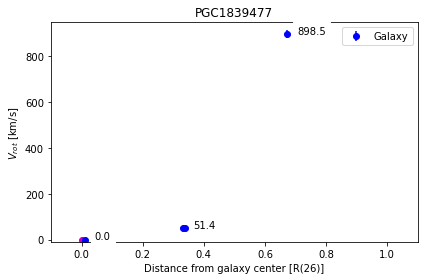

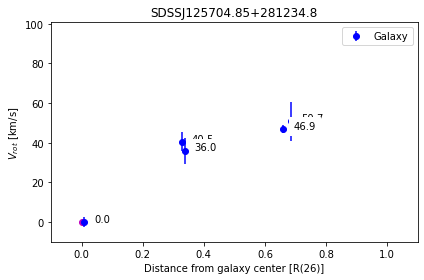

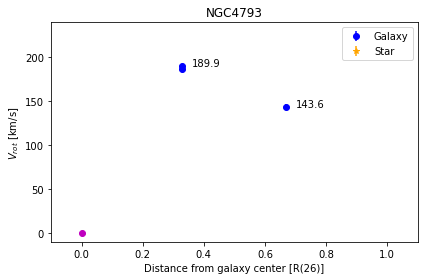

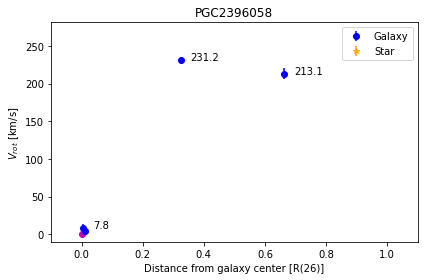

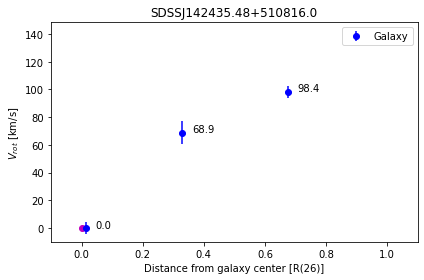

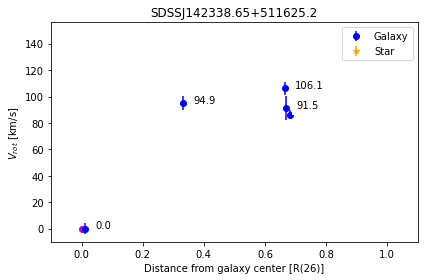

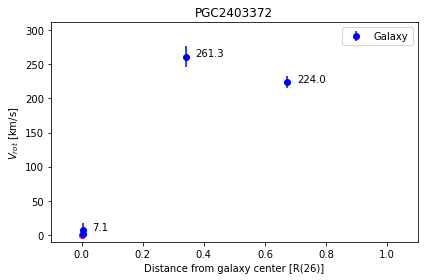

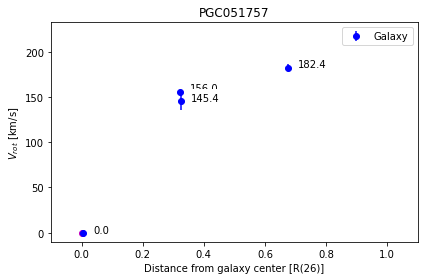

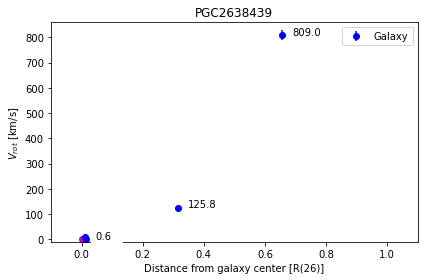

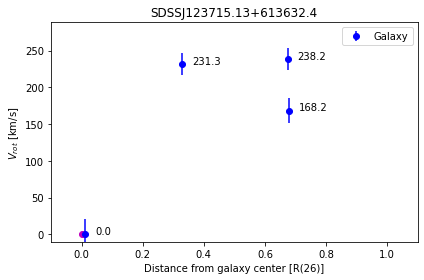

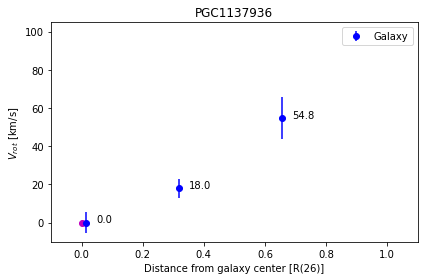

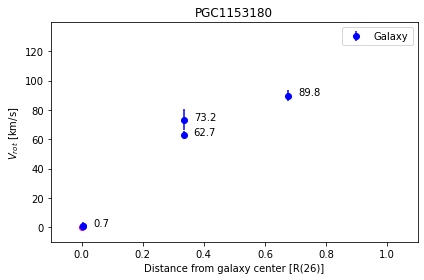

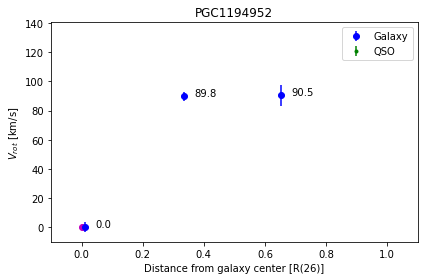

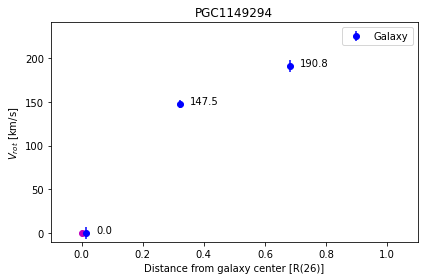

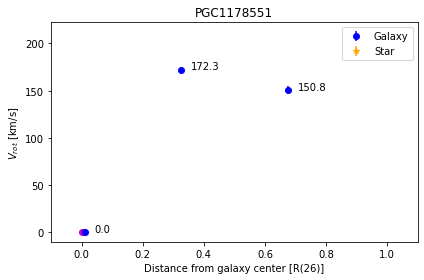

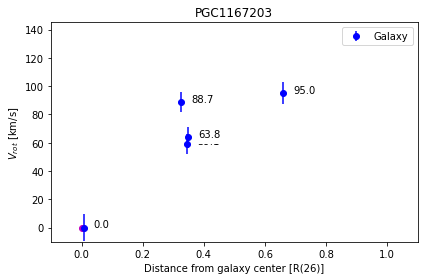

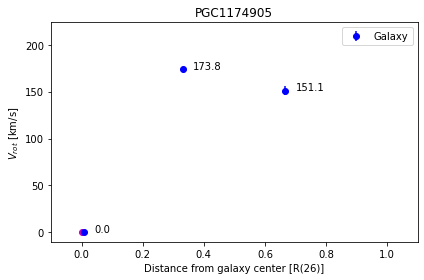

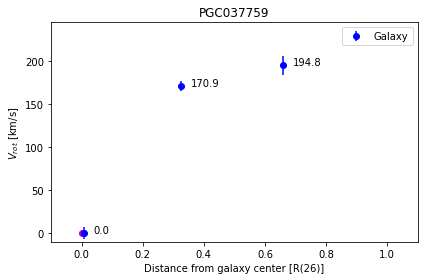

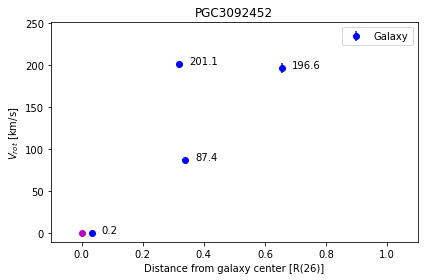

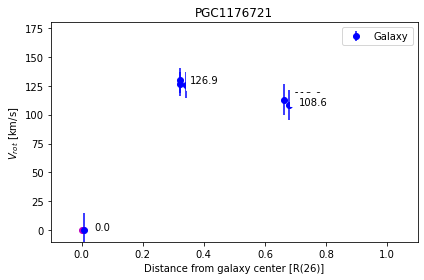

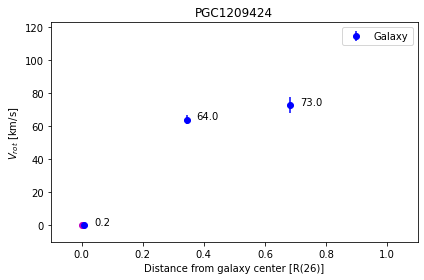

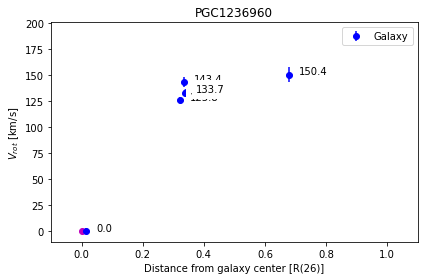

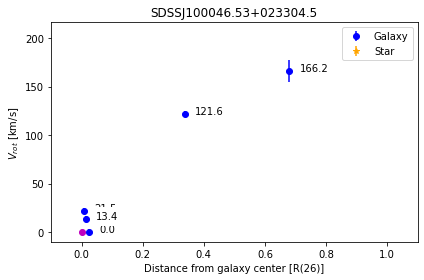

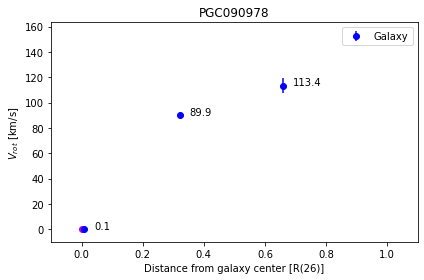

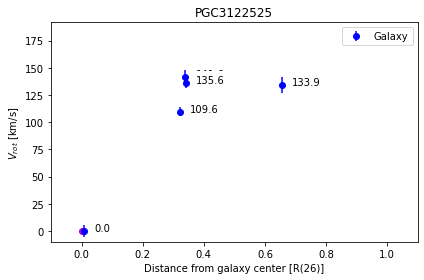

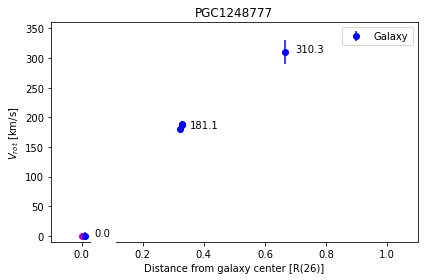

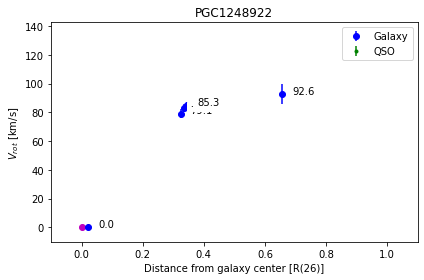

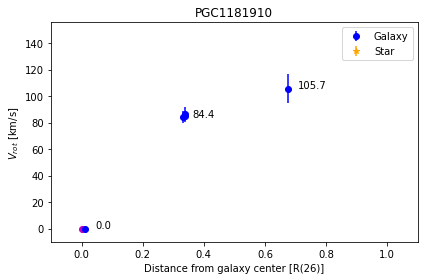

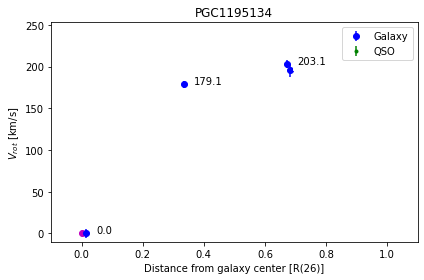

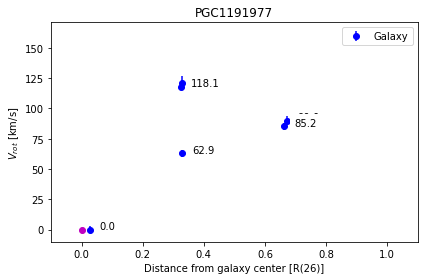

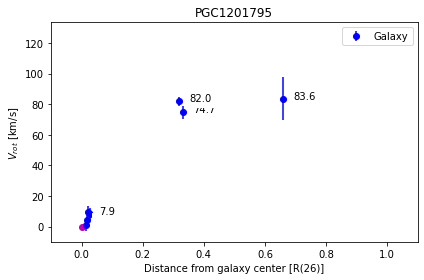

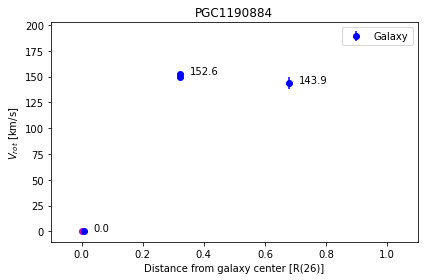

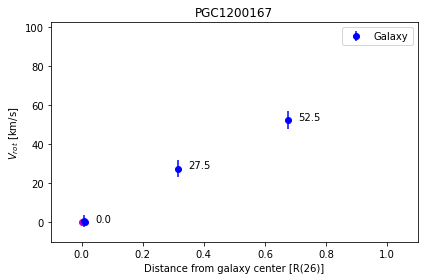

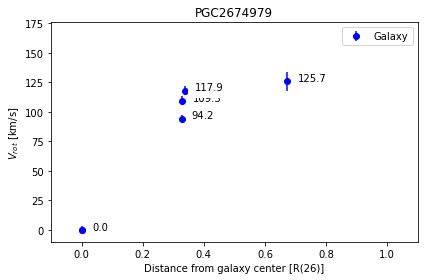

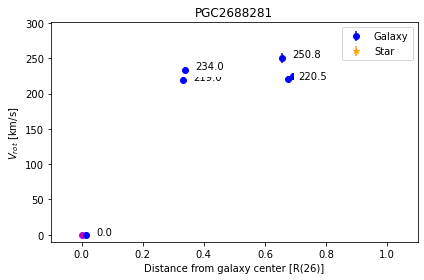

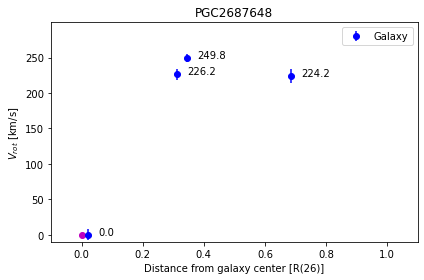

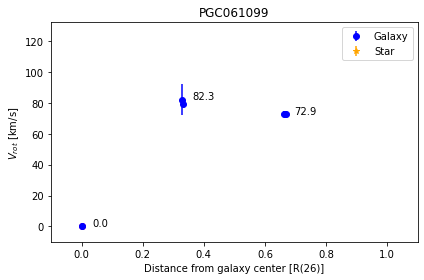

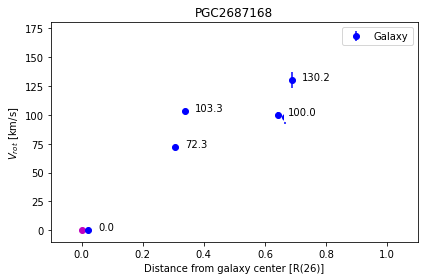

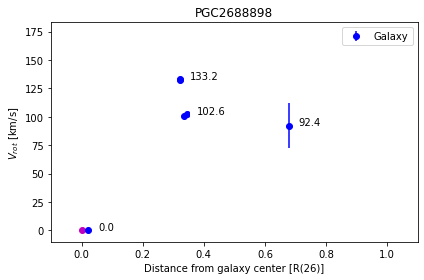

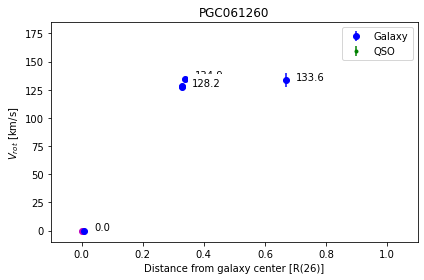

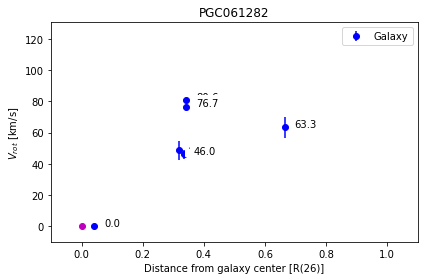

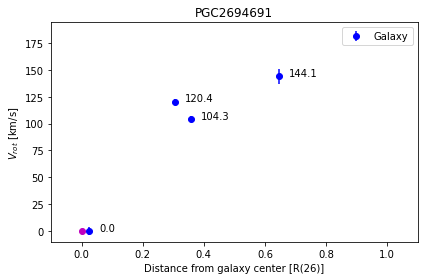

In [42]:
v_diff = []

for i in np.unique(PV_SGA_ztable['IDX_SGA']):
    idx_bool = PV_SGA_ztable['IDX_SGA'] == i
    
    PV_galaxy = PV_SGA_ztable[idx_bool]
    
    ################################################################################
    # Do we have a good observation at at least 2 different radii?
    #-------------------------------------------------------------------------------
    good_bool = np.abs(PV_galaxy['V_ROT']) < 1000*u.km/u.s
    
    num_0p3 = np.sum(np.logical_and(PV_galaxy['RADIUS'][good_bool] > 0.3, 
                                    PV_galaxy['RADIUS'][good_bool] < 0.35))
    
    num_0p6 = np.sum(np.logical_and(PV_galaxy['RADIUS'][good_bool] > 0.6, 
                                    PV_galaxy['RADIUS'][good_bool] < 0.7))

    num_1 = np.sum(PV_galaxy['RADIUS'][good_bool] > 0.95)
    
    check = [num_0p3 > 0, num_0p6 > 0, num_1 > 0]
    
    if sum(check) > 1:
        #print(PV_galaxy['RADIUS', 'V_ROT'])
        ymax = np.max(np.abs(PV_galaxy['V_ROT'][np.abs(PV_galaxy['V_ROT']) < 1000*u.km/u.s]))
        
        ############################################################################
        # Calculate the difference between the velocity measured at 0.6 and 0.3 R26
        #---------------------------------------------------------------------------
        v0p3 = PV_galaxy['V_ROT'][np.logical_and.reduce([good_bool, 
                                                         PV_galaxy['RADIUS'] > 0.3, 
                                                         PV_galaxy['RADIUS'] < 0.35])]
        v0p6 = PV_galaxy['V_ROT'][np.logical_and.reduce([good_bool, 
                                                         PV_galaxy['RADIUS'] > 0.6, 
                                                         PV_galaxy['RADIUS'] < 0.7])]
        
        dv = np.mean(np.abs(v0p6)) - np.mean(np.abs(v0p3))
        v_diff.append(dv.value)
        ############################################################################
        
        
        ############################################################################
        # Plot rotation curve
        #---------------------------------------------------------------------------
        plt.figure()
        plt.title(SGA['GALAXY'][i])
        plt.plot(0, 0, 'mo')

        if 'GALAXY' in PV_galaxy['SPECTYPE']:
            plt.errorbar(PV_galaxy['RADIUS'][PV_galaxy['SPECTYPE'] == 'GALAXY'], 
                         np.abs(PV_galaxy['V_ROT'][PV_galaxy['SPECTYPE'] == 'GALAXY'].data), 
                         yerr=PV_galaxy['V_ROT_ERR'][PV_galaxy['SPECTYPE'] == 'GALAXY'].data, 
                         fmt='o', c='b', label='Galaxy')
        if 'STAR' in PV_galaxy['SPECTYPE']:
            plt.errorbar(PV_galaxy['RADIUS'][PV_galaxy['SPECTYPE'] == 'STAR'], 
                         np.abs(PV_galaxy['V_ROT'][PV_galaxy['SPECTYPE'] == 'STAR'].data), 
                         yerr=PV_galaxy['V_ROT_ERR'][PV_galaxy['SPECTYPE'] == 'STAR'].data, 
                         fmt='*', c='orange', label='Star')
        if 'QSO' in PV_galaxy['SPECTYPE']:
            plt.errorbar(PV_galaxy['RADIUS'][PV_galaxy['SPECTYPE'] == 'QSO'], 
                         np.abs(PV_galaxy['V_ROT'][PV_galaxy['SPECTYPE'] == 'QSO'].data), 
                         yerr=PV_galaxy['V_ROT_ERR'][PV_galaxy['SPECTYPE'] == 'QSO'].data, 
                         fmt='.', c='g', label='QSO')

        for (r,v) in zip(PV_galaxy['RADIUS'].data, np.abs(PV_galaxy['V_ROT'].data)):
            if v < 1000:
                label = '{:.1f}'.format(v)

                plt.annotate(label, 
                             (r,v), 
                             textcoords='offset points', 
                             xytext=(10,0), 
                             backgroundcolor='white')
        
        plt.xlim((-0.1, 1.1))
        plt.ylim((-10,ymax.value + 50))
        
        plt.xlabel('Distance from galaxy center [R(26)]')
        plt.ylabel('$V_{rot}$ [km/s]')
        plt.legend()
        plt.tight_layout()

        plt.show()
        plt.close()
        ############################################################################
    ################################################################################
    
    #break

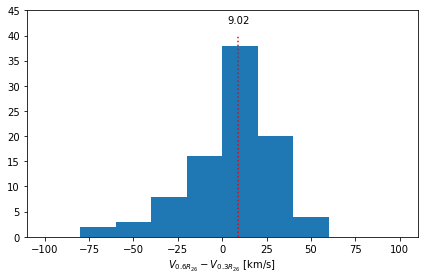

In [45]:
plt.figure()

plt.hist(np.array(v_diff), bins=np.linspace(-100,100,11))
plt.vlines(np.median(v_diff), 0,40, colors='r', linestyles=':')

plt.annotate('{:.2f}'.format(np.median(v_diff)), 
             (np.median(v_diff), 40.5), 
             textcoords='offset points', 
             xytext=(0,10), 
             #backgroundcolor='white', 
             ha='center')

plt.ylim(ymax=45)

plt.xlabel('$V_{0.6R_{26}} - V_{0.3R_{26}}$ [km/s]')

plt.tight_layout()

plt.savefig('../images/SV3_vdiff.png', dpi=300, transparent=True)

# Observation statistics

### What is the distribution of classification of the spectra (galaxy, star, qso) by Redrock?

In [21]:
r0p3 = np.logical_and(PV_SGA_ztable['RADIUS'] > 0.3, PV_SGA_ztable['RADIUS'] < 0.35)
r0p6 = np.logical_and(PV_SGA_ztable['RADIUS'] > 0.6, PV_SGA_ztable['RADIUS'] < 0.7)
r1 = PV_SGA_ztable['RADIUS'] > 0.95

bright = np.logical_or.reduce([PV_SGA_ztable['PROGRAM'] == 'PV_BRIGHT_HIGH', 
                               PV_SGA_ztable['PROGRAM'] == 'PV_BRIGHT_MID', 
                               PV_SGA_ztable['PROGRAM'] == 'PV_BRIGHT_LOW'])
dark = np.logical_or.reduce([PV_SGA_ztable['PROGRAM'] == 'PV_DARK_HIGH', 
                             PV_SGA_ztable['PROGRAM'] == 'PV_DARK_MID', 
                             PV_SGA_ztable['PROGRAM'] == 'PV_DARK_LOW'])

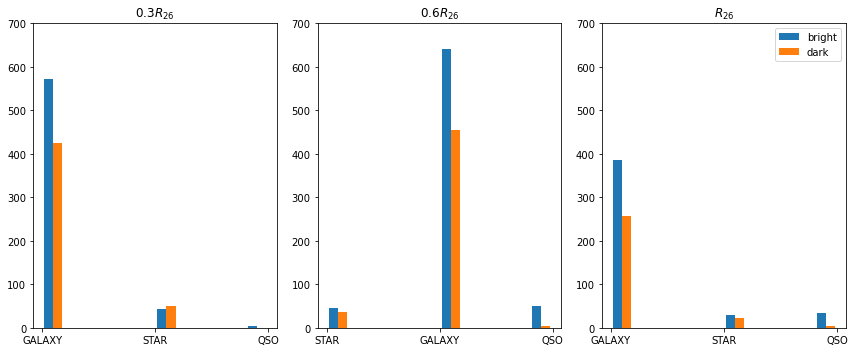

In [30]:
plt.figure(figsize=(12,5))

plt.subplot(131)
plt.hist([PV_SGA_ztable['SPECTYPE'][np.logical_and(r0p3, bright)], 
          PV_SGA_ztable['SPECTYPE'][np.logical_and(r0p3, dark)]], 
         label=['bright', 'dark'])
plt.title('$0.3R_{26}$')
plt.ylim(ymax=700)

plt.subplot(132)
plt.hist([PV_SGA_ztable['SPECTYPE'][np.logical_and(r0p6, bright)], 
          PV_SGA_ztable['SPECTYPE'][np.logical_and(r0p6, dark)]], 
         label=['bright', 'dark'])
plt.title('$0.6R_{26}$')
plt.ylim(ymax=700)

plt.subplot(133)
plt.hist([PV_SGA_ztable['SPECTYPE'][np.logical_and(r1, bright)], 
          PV_SGA_ztable['SPECTYPE'][np.logical_and(r1, dark)]], 
         label=['bright', 'dark'])
plt.title('$R_{26}$')
plt.ylim(ymax=700)
plt.legend()

plt.tight_layout()

### What is the distribution in velocity uncertainties at each radius?

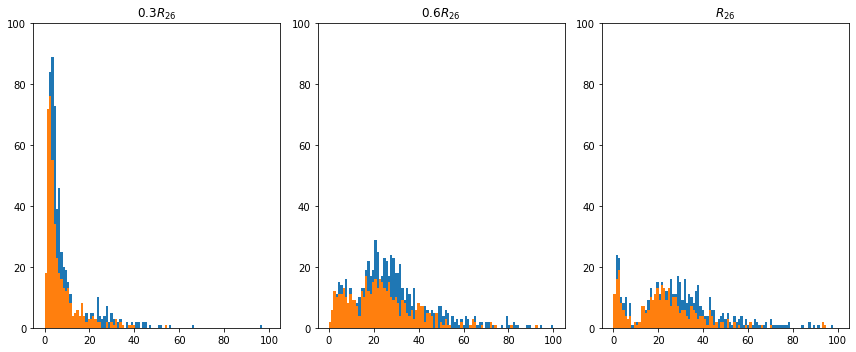

In [48]:
plt.figure(figsize=(12,5))

zerr_bins = np.linspace(0,0.002, 50)
verr_bins = np.linspace(0,100, 100)

plt.subplot(131)
plt.hist(PV_SGA_ztable['V_ROT_ERR'][np.logical_and(r0p3, bright)].data, 
         bins=verr_bins, label='bright')
plt.hist(PV_SGA_ztable['V_ROT_ERR'][np.logical_and(r0p3, dark)].data, 
         bins=verr_bins, label='dark')
plt.title('$0.3R_{26}$')
plt.ylim(ymax=100)

plt.subplot(132)
plt.hist(PV_SGA_ztable['V_ROT_ERR'][np.logical_and(r0p6, bright)].data, 
         bins=verr_bins, label='bright')
plt.hist(PV_SGA_ztable['V_ROT_ERR'][np.logical_and(r0p6, dark)].data, 
         bins=verr_bins, label='dark')
plt.title('$0.6R_{26}$')
plt.ylim(ymax=100)

plt.subplot(133)
plt.hist(PV_SGA_ztable['V_ROT_ERR'][np.logical_and(r1, bright)].data, 
         bins=verr_bins, label='bright')
plt.hist(PV_SGA_ztable['V_ROT_ERR'][np.logical_and(r1, dark)].data, 
         bins=verr_bins, label='dark')
plt.title('$R_{26}$')
plt.ylim(ymax=100)

plt.tight_layout()

### What is the distribution in velocities at each radius?

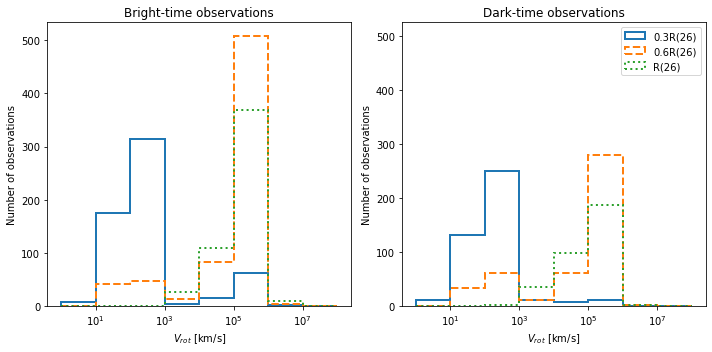

In [49]:
plt.figure(figsize=(10,5))

v_bins = np.logspace(0,8, 9)
lwidth = 2

plt.subplot(121)
plt.hist(np.abs(PV_SGA_ztable['V_ROT'][np.logical_and(r0p3, bright)].data), 
         bins=v_bins, 
         histtype='step', 
         linewidth=lwidth, 
         label='0.3R(26)')

plt.hist(np.abs(PV_SGA_ztable['V_ROT'][np.logical_and(r0p6, bright)].data), 
         bins=v_bins, 
         histtype='step', 
         linewidth=lwidth, 
         linestyle='--',
         label='0.6R(26)')

plt.hist(np.abs(PV_SGA_ztable['V_ROT'][np.logical_and(r1, bright)].data), 
         bins=v_bins, 
         histtype='step', 
         linewidth=lwidth, 
         linestyle=':',
         label='R(26)')

plt.xscale('log')

plt.title('Bright-time observations')
plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('Number of observations')



plt.subplot(122)
plt.hist(np.abs(PV_SGA_ztable['V_ROT'][np.logical_and(r0p3, dark)].data), 
         bins=v_bins, 
         histtype='step', 
         linewidth=lwidth, 
         label='0.3R(26)')

plt.hist(np.abs(PV_SGA_ztable['V_ROT'][np.logical_and(r0p6, dark)].data), 
         bins=v_bins, 
         histtype='step', 
         linewidth=lwidth, 
         linestyle='--',
         label='0.6R(26)')

plt.hist(np.abs(PV_SGA_ztable['V_ROT'][np.logical_and(r1, dark)].data), 
         bins=v_bins, 
         histtype='step', 
         linewidth=lwidth, 
         linestyle=':',
         label='R(26)')

plt.xscale('log')
plt.ylim(ymax=525)

plt.title('Dark-time observations')
plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('Number of observations')

plt.legend()

plt.tight_layout()

plt.savefig('../images/SV3_Vrot_hist.png', dpi=300, transparent=True)

In [28]:
v_max = 1000*u.km/u.s
chi2_max = 25

# 0.3R26
print('0.33 R26 (N =', sum(r0p3), ')')
print('----------------------------------------------------')
print('Fraction of successful redshifts', 
      np.sum(PV_SGA_ztable['V_ROT'][r0p3] < v_max)/np.sum(r0p3))
print('Fraction of failed redshifts', 
      np.sum(PV_SGA_ztable['V_ROT'][r0p3] > v_max)/np.sum(r0p3))
print('Fraction of successful redshifts (DELTACHI2 >', chi2_max, '& ZWARN == 0)', 
      np.sum(np.logical_and(PV_SGA_ztable['DELTACHI2'][r0p3] > chi2_max, 
                            PV_SGA_ztable['ZWARN'][r0p3] == 0))/np.sum(r0p3))
print('Number of observations with "successful" redshifts but fail either DELTACHI2 or ZWARN', 
      np.sum(np.logical_and(PV_SGA_ztable['V_ROT'][r0p3] < v_max, 
                            np.logical_or(PV_SGA_ztable['DELTACHI2'][r0p3] <= chi2_max, 
                                          PV_SGA_ztable['ZWARN'][r0p3] != 0))))
print('Fraction of successful redshifts during bright time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p3, bright)] < v_max)/np.sum(np.logical_and(r0p3, bright)))
print('Fraction of failed redshifts during bright time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p3, bright)] > v_max)/np.sum(np.logical_and(r0p3, bright)))
print('Fraction of successful redshifts during dark time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p3, dark)] < v_max)/np.sum(np.logical_and(r0p3, dark)))
print('Fraction of failed redshifts during dark time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p3, dark)] > v_max)/np.sum(np.logical_and(r0p3, dark)))
print('\n')

# 0.6R26
print('0.66 R26 (N =', sum(r0p6), ')')
print('----------------------------------------------------')
print('Fraction of successful redshifts', 
      np.sum(PV_SGA_ztable['V_ROT'][r0p6] < v_max)/np.sum(r0p6))
print('Fraction of failed redshifts', 
      np.sum(PV_SGA_ztable['V_ROT'][r0p6] > v_max)/np.sum(r0p6))
print('Fraction of successful redshifts (DELTACHI2 >', chi2_max, '& ZWARN == 0)', 
      np.sum(np.logical_and(PV_SGA_ztable['DELTACHI2'][r0p6] > chi2_max, 
                            PV_SGA_ztable['ZWARN'][r0p6] == 0))/np.sum(r0p6))
print('Number of observations with "successful" redshifts but fail either DELTACHI2 or ZWARN', 
      np.sum(np.logical_and(PV_SGA_ztable['V_ROT'][r0p6] < v_max, 
                            np.logical_or(PV_SGA_ztable['DELTACHI2'][r0p6] <= chi2_max, 
                                          PV_SGA_ztable['ZWARN'][r0p6] != 0))))
print('Fraction of successful redshifts during bright time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p6, bright)] < v_max)/np.sum(np.logical_and(r0p6, bright)))
print('Fraction of failed redshifts during bright time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p6, bright)] > v_max)/np.sum(np.logical_and(r0p6, bright)))
print('Fraction of successful redshifts during dark time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p6, dark)] < v_max)/np.sum(np.logical_and(r0p6, dark)))
print('Fraction of failed redshifts during dark time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r0p6, dark)] > v_max)/np.sum(np.logical_and(r0p6, dark)))
print('\n')

# R26
print('R26 (N =', sum(r1), ')')
print('----------------------------------------------------')
print('Fraction of successful redshifts', 
      np.sum(PV_SGA_ztable['V_ROT'][r1] < v_max)/np.sum(r1))
print('Fraction of failed redshifts', 
      np.sum(PV_SGA_ztable['V_ROT'][r1] > v_max)/np.sum(r1))
print('Fraction of successful redshifts (DELTACHI2 >', chi2_max, '& ZWARN == 0)', 
      np.sum(np.logical_and(PV_SGA_ztable['DELTACHI2'][r1] > chi2_max, 
                            PV_SGA_ztable['ZWARN'][r1] == 0))/np.sum(r1))
print('Number of observations with "successful" redshifts but fail either DELTACHI2 or ZWARN', 
      np.sum(np.logical_and(PV_SGA_ztable['V_ROT'][r1] < v_max, 
                            np.logical_or(PV_SGA_ztable['DELTACHI2'][r1] <= chi2_max, 
                                          PV_SGA_ztable['ZWARN'][r1] != 0))))
print('Fraction of successful redshifts during bright time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r1, bright)] < v_max)/np.sum(np.logical_and(r1, bright)))
print('Fraction of failed redshifts during bright time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r1, bright)] > v_max)/np.sum(np.logical_and(r1, bright)))
print('Fraction of successful redshifts during dark time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r1, dark)] < v_max)/np.sum(np.logical_and(r1, dark)))
print('Fraction of failed redshifts during dark time', 
      np.sum(PV_SGA_ztable['V_ROT'][np.logical_and(r1, dark)] > v_max)/np.sum(np.logical_and(r1, dark)))

0.33 R26 (N = 1080 )
----------------------------------------------------
Fraction of successful redshifts 0.9138888888888889
Fraction of failed redshifts 0.08611111111111111
Fraction of successful redshifts (DELTACHI2 > 25 & ZWARN == 0) 0.8685185185185185
Number of observations with "successful" redshifts but fail either DELTACHI2 or ZWARN 69
Fraction of successful redshifts during bright time 0.8714524207011686
Fraction of failed redshifts during bright time 0.1285475792988314
Fraction of successful redshifts during dark time 0.9666666666666667
Fraction of failed redshifts during dark time 0.03333333333333333


0.66 R26 (N = 1233 )
----------------------------------------------------
Fraction of successful redshifts 0.25060827250608275
Fraction of failed redshifts 0.7493917274939172
Fraction of successful redshifts (DELTACHI2 > 25 & ZWARN == 0) 0.145985401459854
Number of observations with "successful" redshifts but fail either DELTACHI2 or ZWARN 158
Fraction of successful redshifts 

### Is there a correlation between inclination angle and a successful redshift?

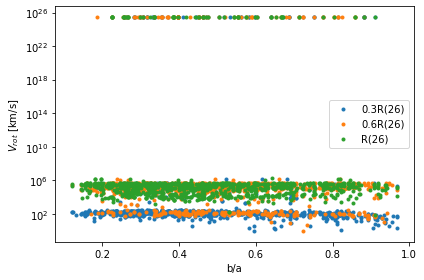

In [50]:
plt.figure()

r0p3 = np.logical_and(PV_SGA_ztable['RADIUS'] > 0.3, PV_SGA_ztable['RADIUS'] < 0.35)
plt.semilogy(SGA['BA'][PV_SGA_ztable['IDX_SGA'][r0p3]], 
             np.abs(PV_SGA_ztable['V_ROT'][r0p3]), '.', label='0.3R(26)')

r0p6 = np.logical_and(PV_SGA_ztable['RADIUS'] > 0.6, PV_SGA_ztable['RADIUS'] < 0.7)
plt.semilogy(SGA['BA'][PV_SGA_ztable['IDX_SGA'][r0p6]], 
             np.abs(PV_SGA_ztable['V_ROT'][r0p6]), '.', label='0.6R(26)')

r1 = PV_SGA_ztable['RADIUS'] > 0.95
plt.semilogy(SGA['BA'][PV_SGA_ztable['IDX_SGA'][r1]], 
             np.abs(PV_SGA_ztable['V_ROT'][r1]), '.', label='R(26)')

plt.xlabel('b/a')
plt.ylabel('$V_{rot}$ [km/s]')

plt.legend()

plt.tight_layout()

# How does $R_{26}$ compare to $0.72R_{23.5}$?

$0.72 R_{23.5}$ is the faintest radius at which David Schlegal determined is the furthest one can go in a galaxy and still detect H$\alpha$.

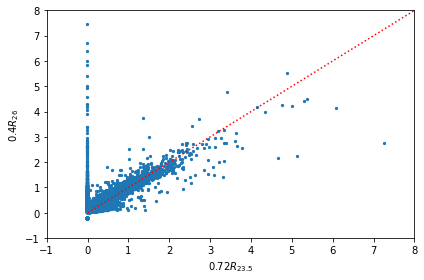

In [69]:
plt.figure()

SGA_23p5 = SGA['RADIUS_SB23.5']*u.arcsec.to(u.arcmin)

plt.scatter(0.72*SGA_23p5.data, 0.4*0.5*SGA['DIAM'].data, s=5)
plt.plot([0,10], [0,10], 'r:')
#plt.hlines()

plt.ylabel('$0.4R_{26}$')
plt.xlabel('$0.72R_{23.5}$')

plt.ylim((-1,8))
plt.xlim((-1,8))

plt.tight_layout()